In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.utils import make_grid, save_image

sys.path.append("./")
writer = SummaryWriter()
device = "cuda"  if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
def show_samples(images, row, col, image_shape, name="Unknown", save=True, shift=False):
    num_images = row * col
    if shift:
        images = (images + 1.) / 2.
    fig = plt.figure(figsize=(col, row))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(row, col),
                     axes_pad=0.)
    for i in range(num_images):
        im = images[i].reshape(image_shape)
        axis = grid[i]
        axis.axis('off')
        axis.imshow(im.cpu().detach().numpy())
    plt.axis('off')
    plt.tight_layout()
    if save:
        fig.savefig(name + '.png', bbox_inches="tight", pad_inches=0, format='png')
    plt.show()

In [5]:

class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition         self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        # x = F.relu(self.linear1(x))
        # return F.relu(self.linear2(x))
        
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)  # 8 -> 100
        self.linear2 = torch.nn.Linear(H, D_out)  # 100 -> 28 * 28
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.sigmoid(self.linear2(x))

In [8]:
class VAE(torch.nn.Module):
    latent_dim = 8
    
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8).to(device)
        self._enc_log_sigma = torch.nn.Linear(100, 8).to(device)
    
    def _sample_latent(self, h_enc):
        """ Return the latent normal sample z ~ N(mu, sigma^2) """
        mu = self._enc_mu(h_enc)  # 100 -> 8
        log_sigma = self._enc_log_sigma(h_enc)  # 100 -> 8
        sigma = torch.exp(0.5 * log_sigma)  # 100 -> 8, need 0.5 to replace sqrt()
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float().to(device)  # 从 0，1 标准分布中抽取一个z变量
        
        self.z_mean = mu
        self.z_sigma = sigma
        
        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
    
    def forward(self, state):
        h_enc = self.encoder(state)  # 28 * 28 -> 100 -> 100
        z = self._sample_latent(h_enc)  # -> 8
        return self.decoder(z)  # 8 -> 100 -> 28 * 28

In [16]:
# 这部分是编码器生成与正态分布的差别，在loss中占一部分
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.sum(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


In [17]:
def show_generator(decoder):
    test_latent_vals = torch.randn((16, 8)).to(device)
    output = decoder(test_latent_vals)
    # output = torch.sigmoid(output)
    print("print outputs")
    show_samples(output, 4, 4, [28, 28], name="Unknown", save=True)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', './']
Number of samples:  60000


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 
 total_loss  333.91663853327435 
 KL_loss  9117.234320998192 
 reconstruction_loss 160994.98895263672 ---- 

1 
 total_loss  221.18988227844238 
 KL_loss  8337.803716023764 
 reconstruction_loss 104201.32053629558 ---- 

2 
 total_loss  195.5194789568583 
 KL_loss  8885.918268839518 
 reconstruction_loss 90570.14758300781 ---- 

3 
 total_loss  181.9112408955892 
 KL_loss  9207.066005706787 
 reconstruction_loss 83322.46797688802 ---- 

4 
 total_loss  173.72634522120157 
 KL_loss  9308.714970906576 
 reconstruction_loss 79060.90656534831 ---- 

5 
 total_loss  169.20217355092367 
 KL_loss  9231.510551452637 
 reconstruction_loss 76810.90774536133 ---- 

6 
 total_loss  166.04685974121094 
 KL_loss  9143.146957397461 
 reconstruction_loss 75292.86191813152 ---- 

7 
 total_loss  163.75665410359701 
 KL_loss  9118.885492960611 
 reconstruction_loss 74128.8978881836 ---- 

8 
 total_loss  161.7997443675995 
 KL_loss  9074.272084554037 
 reconstruction_loss 73209.58005777995 ---- 

9 


<ipython-input-4-e91077ee5d8b>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


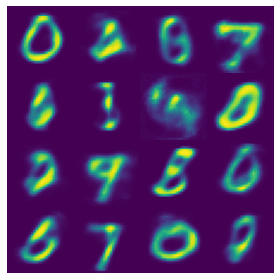

11 
 total_loss  157.76520721117654 
 KL_loss  9077.259407043457 
 reconstruction_loss 71145.5266011556 ---- 

12 
 total_loss  156.7573551336924 
 KL_loss  9098.484135945639 
 reconstruction_loss 70639.36315917969 ---- 

13 
 total_loss  155.87449796994528 
 KL_loss  9117.914615631104 
 reconstruction_loss 70144.97615559895 ---- 

14 
 total_loss  155.08071144421896 
 KL_loss  9132.677200317383 
 reconstruction_loss 69725.56368001302 ---- 

15 
 total_loss  154.43000038464865 
 KL_loss  9162.35977045695 
 reconstruction_loss 69339.96349080403 ---- 

16 
 total_loss  153.72084108988443 
 KL_loss  9194.236326853434 
 reconstruction_loss 68979.1498413086 ---- 

17 
 total_loss  153.21560422579446 
 KL_loss  9229.727528889975 
 reconstruction_loss 68686.02437337239 ---- 

18 
 total_loss  152.6732808748881 
 KL_loss  9242.530376434326 
 reconstruction_loss 68381.51588948567 ---- 

19 
 total_loss  152.09736839930216 
 KL_loss  9261.939520517984 
 reconstruction_loss 68087.78177897136 ----

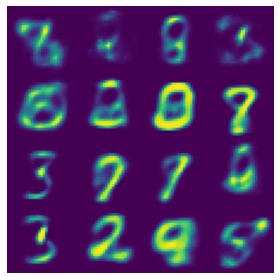

21 
 total_loss  151.21484971046448 
 KL_loss  9296.044064839682 
 reconstruction_loss 67617.36729939778 ---- 

22 
 total_loss  150.85787177085876 
 KL_loss  9327.152448018393 
 reconstruction_loss 67388.69152832031 ---- 

23 
 total_loss  150.49252462387085 
 KL_loss  9343.58914311727 
 reconstruction_loss 67176.97285970052 ---- 

24 
 total_loss  150.14828205108643 
 KL_loss  9355.01551437378 
 reconstruction_loss 66979.30453491211 ---- 

25 
 total_loss  149.7619709968567 
 KL_loss  9371.878623962402 
 reconstruction_loss 66774.66109212239 ---- 

26 
 total_loss  149.52354486783346 
 KL_loss  9394.124979654947 
 reconstruction_loss 66613.21370442708 ---- 

27 
 total_loss  149.13289165496826 
 KL_loss  9402.367822011312 
 reconstruction_loss 66440.19122314453 ---- 

28 
 total_loss  148.89985624949136 
 KL_loss  9434.278963724772 
 reconstruction_loss 66295.8205464681 ---- 

29 
 total_loss  148.57168793678284 
 KL_loss  9436.890783945719 
 reconstruction_loss 66141.98221842448 ---

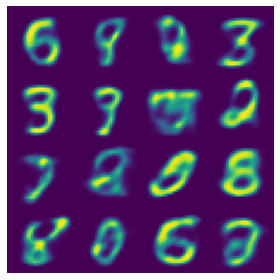

31 
 total_loss  148.17965714136758 
 KL_loss  9460.667455037436 
 reconstruction_loss 65868.4731241862 ---- 

32 
 total_loss  147.94605016708374 
 KL_loss  9484.404568990072 
 reconstruction_loss 65746.55085245769 ---- 

33 
 total_loss  147.7575275103251 
 KL_loss  9502.818148295084 
 reconstruction_loss 65631.62829589844 ---- 

34 
 total_loss  147.52006713549295 
 KL_loss  9514.356658935547 
 reconstruction_loss 65516.814514160156 ---- 

35 
 total_loss  147.33159112930298 
 KL_loss  9508.736015319824 
 reconstruction_loss 65399.38293457031 ---- 

36 
 total_loss  147.21283928553262 
 KL_loss  9531.287439982096 
 reconstruction_loss 65301.06114705404 ---- 

37 
 total_loss  146.944132010142 
 KL_loss  9541.201508839926 
 reconstruction_loss 65196.339599609375 ---- 

38 
 total_loss  146.77874541282654 
 KL_loss  9555.62391281128 
 reconstruction_loss 65085.32539876302 ---- 

39 
 total_loss  146.65329027175903 
 KL_loss  9564.8817431132 
 reconstruction_loss 64976.828521728516 ---

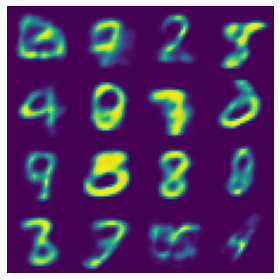

41 
 total_loss  146.35471359888712 
 KL_loss  9591.084401448568 
 reconstruction_loss 64822.873697916664 ---- 

42 
 total_loss  146.20514941215515 
 KL_loss  9600.111836751303 
 reconstruction_loss 64725.68822224935 ---- 

43 
 total_loss  146.034658908844 
 KL_loss  9601.08318456014 
 reconstruction_loss 64650.554361979164 ---- 

44 
 total_loss  145.892528851827 
 KL_loss  9620.404216766357 
 reconstruction_loss 64562.99278767904 ---- 

45 
 total_loss  145.7468320528666 
 KL_loss  9632.517337799072 
 reconstruction_loss 64481.05214436849 ---- 

46 
 total_loss  145.6862420241038 
 KL_loss  9624.854771931967 
 reconstruction_loss 64420.52238972982 ---- 

47 
 total_loss  145.5247573852539 
 KL_loss  9645.97012837728 
 reconstruction_loss 64352.59360758463 ---- 

48 
 total_loss  145.41870212554932 
 KL_loss  9635.691824595133 
 reconstruction_loss 64279.65710449219 ---- 

49 
 total_loss  145.31949170430502 
 KL_loss  9641.837707519531 
 reconstruction_loss 64230.47014363607 ---- 


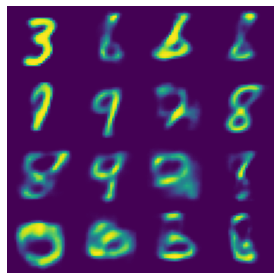

51 
 total_loss  144.98623339335123 
 KL_loss  9666.003365834555 
 reconstruction_loss 64082.33860270182 ---- 

52 
 total_loss  144.99824770291647 
 KL_loss  9665.814239501953 
 reconstruction_loss 64040.28409830729 ---- 

53 
 total_loss  144.799729347229 
 KL_loss  9693.140419006348 
 reconstruction_loss 63956.192443847656 ---- 

54 
 total_loss  144.77592555681863 
 KL_loss  9691.080594380697 
 reconstruction_loss 63905.18672688802 ---- 

55 
 total_loss  144.61653765042624 
 KL_loss  9694.924407958984 
 reconstruction_loss 63865.55206298828 ---- 

56 
 total_loss  144.4406582514445 
 KL_loss  9687.873502095541 
 reconstruction_loss 63785.52433268229 ---- 

57 
 total_loss  144.47941454251608 
 KL_loss  9706.820187886557 
 reconstruction_loss 63746.64221191406 ---- 

58 
 total_loss  144.3632713953654 
 KL_loss  9699.684028625488 
 reconstruction_loss 63692.20221964518 ---- 

59 
 total_loss  144.25361140569052 
 KL_loss  9706.867973327637 
 reconstruction_loss 63650.4921875 ---- 


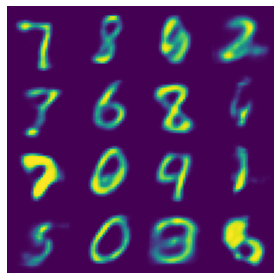

61 
 total_loss  144.08029953638712 
 KL_loss  9723.589785257975 
 reconstruction_loss 63541.501485188805 ---- 

62 
 total_loss  143.96620949109396 
 KL_loss  9720.681640625 
 reconstruction_loss 63488.17077636719 ---- 

63 
 total_loss  143.84612075487772 
 KL_loss  9730.788393656412 
 reconstruction_loss 63452.17787679037 ---- 

64 
 total_loss  143.8673103650411 
 KL_loss  9746.235244750977 
 reconstruction_loss 63407.395334879555 ---- 

65 
 total_loss  143.7835143407186 
 KL_loss  9732.489589691162 
 reconstruction_loss 63366.52952067057 ---- 

66 
 total_loss  143.7561636765798 
 KL_loss  9745.093915303549 
 reconstruction_loss 63341.751861572266 ---- 

67 
 total_loss  143.65535489718118 
 KL_loss  9748.794883728027 
 reconstruction_loss 63307.653564453125 ---- 

68 
 total_loss  143.54025212923685 
 KL_loss  9740.453643798828 
 reconstruction_loss 63257.4228515625 ---- 

69 
 total_loss  143.55123686790466 
 KL_loss  9765.05905532837 
 reconstruction_loss 63214.20294189453 ---

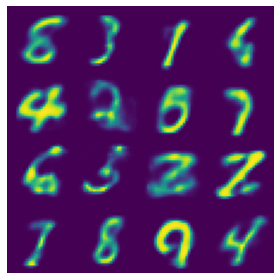

71 
 total_loss  143.3699205716451 
 KL_loss  9770.132336934408 
 reconstruction_loss 63141.55619303385 ---- 

72 
 total_loss  143.34041587511697 
 KL_loss  9782.41121673584 
 reconstruction_loss 63107.281087239586 ---- 

73 
 total_loss  143.25236264864603 
 KL_loss  9777.386876424154 
 reconstruction_loss 63061.52675374349 ---- 



KeyboardInterrupt: ignored

In [18]:
if __name__ == '__main__':
    input_dim = 28 * 28
    batch_size = 512
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    print(sys.path)
    mnist = torchvision.datasets.MNIST('./', transform=transform,
                                       download=True,
                                       )
    
    dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
    
    print('Number of samples: ', len(mnist))
    
    encoder = Encoder(input_dim, 100, 100)
    decoder = Decoder(8, 100, input_dim)
    vae = VAE(encoder, decoder).to(device)
    
    # criterion = nn.MSELoss()
    criterion = lambda recon_x, x: F.binary_cross_entropy(recon_x, x, size_average=False)

    
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    l = None
    total_loss, KL_loss, reconstruction_loss = 0.,0.,0.

    for epoch in range(100):
        for i, data in enumerate(dataloader, 0):
            inputs, classes = data
            inputs, classes = Variable(inputs.resize_(len(inputs), input_dim)).to(device), Variable(classes)
            optimizer.zero_grad()
            dec = vae(inputs)
            ll = latent_loss(vae.z_mean, vae.z_sigma)
            # 损失包含两部分，一部分是正太分布的损失，一部分是生成与预期的损失
            rec_loss = criterion(dec, inputs)
            loss = rec_loss + ll
            loss = loss/len(classes)
            loss.backward()
            optimizer.step()
            l = loss.data
         
            total_loss += loss.item()
            KL_loss += ll.item()
            reconstruction_loss += rec_loss.item()
        
        print(epoch, "\n total_loss ", total_loss/len(classes),
                "\n KL_loss ", KL_loss/len(classes),
                "\n reconstruction_loss", reconstruction_loss/len(classes), "---- \n")
        total_loss, KL_loss, reconstruction_loss = 0.,0.,0.
        
        if epoch != 0 and epoch % 10 == 0:
            show_generator(decoder)
            torch.save(vae, "VAE.pth")
    
    writer.close()